In [1]:
import os
import random
import shutil
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
from  IPython import display

plt.rcParams['figure.figsize'] = (12, 8)
print("Version: ", tf.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.15.0
GPU is available


In [2]:
! pip install kymatio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 750.2 kB/s eta 0:00:00


In [3]:
PATH = '/content'
DATA_PATH = '/content/drive/MyDrive/complete_xdcms'

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
def get_dataset_size(path):
    num_of_images = {}
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        num_images_in_folder = len(os.listdir(folder_path))
        num_of_images[folder] = num_images_in_folder
    return num_of_images

In [6]:
new_dataset_size = get_dataset_size(DATA_PATH)
print('New Dataset Size:', new_dataset_size)

New Dataset Size: {'Cancer': 477, 'Non-Cancer': 395}


In [ ]:
!rm -rf /content/dataset

In [7]:
def preprocess_images(input_dir, output_dir, target_size=(256, 256)):

    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    classes = os.listdir(input_dir)
    for class_name in classes:
        class_path = os.path.join(input_dir, class_name)
        if not os.path.isdir(class_path):
            continue


        output_class_path = os.path.join(output_dir, class_name)
        if not os.path.exists(output_class_path):
            os.makedirs(output_class_path)

        images = os.listdir(class_path)
        for image_name in images:
            image_path = os.path.join(class_path, image_name)
            image = cv2.imread(image_path)
            image = cv2.resize(image, target_size)
            gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            output_image_path = os.path.join(output_class_path, image_name)
            cv2.imwrite(output_image_path, gray_image)
    print("Preprocessing completed.")


input_directory = DATA_PATH
output_directory = '/content/dataset'
preprocess_images(input_directory, output_directory)

Preprocessing completed.


In [8]:
PATH = '/content'
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    os.chdir(PATH)
    IMAGES_PATH = PATH +'/images'

    if os.path.isdir(IMAGES_PATH) is False:
        os.mkdir('images')
        IMAGES_PATH = PATH + '/images'
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)

    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    return

In [9]:
def plot_images(path, num_images=16, figsize=(8, 8), save_id=None):
    images = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)
            images.append((image_path, folder))

    plt.figure(figsize=figsize)
    for i in range(num_images):
        random_img = random.choice(images)
        img = plt.imread(random_img[0])
        plt.subplot(4, 4, i + 1)
        plt.axis('off')
        plt.title(random_img[1])
        plt.imshow(img)

    plt.tight_layout()

    if save_id is not None:
        save_fig(save_id)
    plt.show()


Saving figure images_proc


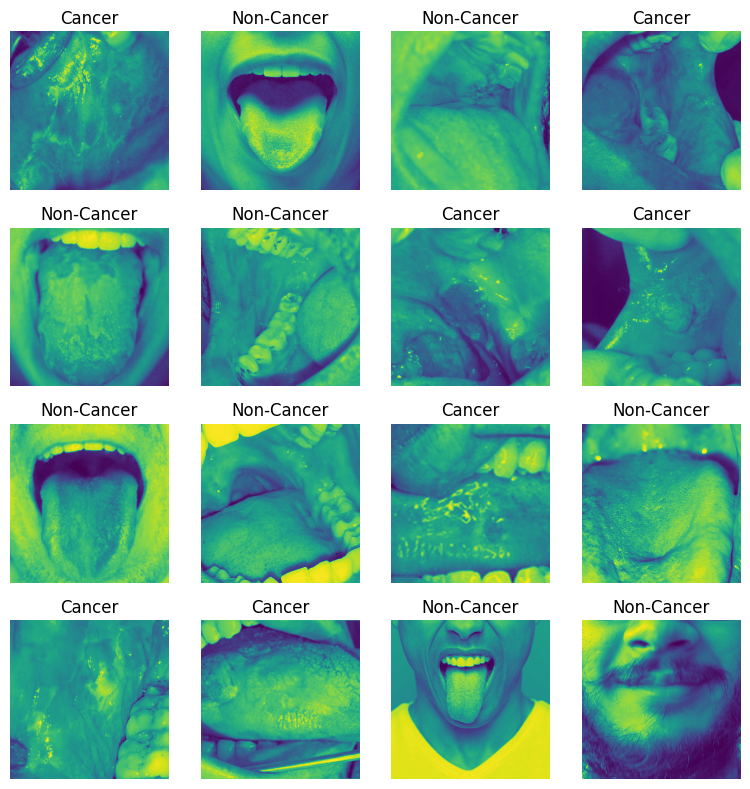

In [10]:
plot_images('/content/dataset', save_id='images_proc')

In [11]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import cv2
import os
import numpy as np

def load_images_from_dir(directory):
    images = []
    labels = []
    for label, sub_dir in enumerate(os.listdir(directory)):
        sub_dir_path = os.path.join(directory, sub_dir)
        for filename in os.listdir(sub_dir_path):
            img_path = os.path.join(sub_dir_path, filename)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            if img is not None:
                # Rescale image to range [0, 1]
                img = img.astype('float32') / 255.0
                images.append(img)
                labels.append(label)
    return images, labels

data_dir = PATH + '/dataset'
images, labels = load_images_from_dir(data_dir)


train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.4, random_state=42)

# Convert train_images to a NumPy array
train_images = np.array(train_images)
train_labels = np.array(train_labels)

test_images = np.array(test_images)
test_labels = np.array(test_labels)

# train_labels = to_categorical(train_labels)
# test_labels = to_categorical(test_labels)

print("Number of training samples:", len(train_images))
print("Number of training labels:", len(train_labels))

print("Number of testing samples:", len(test_images))
print("Number of testing labels:", len(test_labels))


Number of training samples: 523
Number of training labels: 523
Number of testing samples: 349
Number of testing labels: 349


In [12]:
type(train_images[0])

numpy.ndarray

In [13]:
type(train_labels[0])

numpy.int64

In [16]:
import numpy as np
from kymatio.keras import Scattering2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten,Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

In [19]:
J = 2
shape = (256, 256)

scattering = Scattering2D(J=J)


model = Sequential()
model.add(Input(shape=shape))
model.add(scattering)

# model.add(Conv2D(filters=32, kernel_size=(3, 3),padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(1, activation='sigmoid'))


model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=50, batch_size=32, validation_data=(test_images, test_labels))

Epoch 1/50
17/17 [==============================] - 30s 869ms/step - loss: 1.1660 - accuracy: 0.5220 - val_loss: 0.6726 - val_accuracy: 0.5817
Epoch 2/50
17/17 [==============================] - 3s 204ms/step - loss: 0.7099 - accuracy: 0.5354 - val_loss: 0.6847 - val_accuracy: 0.5444
Epoch 3/50
17/17 [==============================] - 5s 282ms/step - loss: 0.6853 - accuracy: 0.5736 - val_loss: 0.6851 - val_accuracy: 0.5444
Epoch 4/50
17/17 [==============================] - 3s 206ms/step - loss: 0.6787 - accuracy: 0.5641 - val_loss: 0.6712 - val_accuracy: 0.6676
Epoch 5/50
17/17 [==============================] - 5s 282ms/step - loss: 0.6674 - accuracy: 0.5927 - val_loss: 0.6778 - val_accuracy: 0.5072
Epoch 6/50
17/17 [==============================] - 5s 284ms/step - loss: 0.6859 - accuracy: 0.5373 - val_loss: 0.6834 - val_accuracy: 0.5301
Epoch 7/50
17/17 [==============================] - 3s 208ms/step - loss: 0.6782 - accuracy: 0.5832 - val_loss: 0.6739 - val_accuracy: 0.5759
Epoch

In [20]:
def plot_training(history, name):
    hist = pd.DataFrame()
    hist["Train Loss"] = history.history['loss']
    hist["Validation Loss"] = history.history['val_loss']
    hist["Train Accuracy"] = history.history['accuracy']
    hist["Validation Accuracy"] = history.history['val_accuracy']

    fig, axarr = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
    axarr[0].set_title("History of Loss in Train and Validation Datasets")
    hist[["Train Loss", "Validation Loss"]].plot(ax=axarr[0])
    axarr[1].set_title("History of Accuracy in Train and Validation Datasets")
    hist[["Train Accuracy", "Validation Accuracy"]].plot(ax=axarr[1])
    save_fig(name)
    plt.show()

In [22]:
model.save('wavelet.keras')

In [ ]:


def create_cnn_model(input_shape=(256, 256)):
    model = Sequential()
    J = 6
    shape = (256, 256)
    scattering = Scattering2D(J=J)

    model.add(Input(256,256))
    model.add(scattering)
    model.add(Conv2D(filters=32, kernel_size=(3, 3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=64, kernel_size=(3, 3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())


    model.add(Conv2D(filters=128, kernel_size=(3, 3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=256, kernel_size=(3, 3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(filters=512, kernel_size=(3, 3),padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(BatchNormalization())


    model.add(Dropout(rate=0.5))
    model.add(Flatten())

    model.add(Dense(units=64, activation='relu'))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
cnn_model = create_cnn_model()
cnn_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_17 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 batch_normalization_17 (Ba  (None, 128, 128, 32)      128       
 tchNormalization)                                               
                                                                 
 conv2d_18 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                      

In [ ]:
model.fit(train_images, train_labels, epochs=32, batch_size=32, validation_data=(test_images, test_labels))

In [ ]:
from math import ceil
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

def image_data_generator(data_dir,class_weights=None):

    datagen = image.ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode="nearest"
        )


    return datagen.flow_from_directory(
        directory=data_dir,
        target_size=(256,256),
        batch_size=16,
        class_mode='binary',
        shuffle = True
    )

def train_model_with_data_generators(model, train_dir, val_dir, epochs=32,class_weight=None):

    train_data = image_data_generator(train_dir)
    val_data = image_data_generator(val_dir)

    print("Train Data:")
    print("Found", train_data.samples, "images belonging to", len(train_data.class_indices), "classes.")
    print("Class Indices:", train_data.class_indices)
    print()

    print("Validation Data:")
    print("Found", val_data.samples, "images belonging to", len(val_data.class_indices), "classes.")
    print()

    mc = ModelCheckpoint(
        filepath="cnn_model.keras",
        monitor='val_accuracy',
        # verbose=1,
        # save_best_only=True,
        mode='auto'
    )
    es = EarlyStopping(
        monitor='val_loss',
        patience=6,
        # restore_best_weights=True,
        verbose=1
    )

    rp = ReduceLROnPlateau(
        monitor='val_accuracy',
        # verbose=1,
        mode='max',
        factor=0.1,
        min_lr=1e-8,
        patience=5
        )
    callbacks = [es,rp,mc]

    # Fitting the Model
    history = model.fit(
        train_data,
        epochs=epochs,
        validation_data=val_data,
        callbacks=callbacks,
        class_weight=class_weight
    )

    return history

In [ ]:
train_dir = "/content/splitted_dataset/train"
val_dir = "/content/splitted_dataset/val"

In [ ]:
training_history = train_model_with_data_generators(cnn_model, train_dir, val_dir,32)

Found 525 images belonging to 2 classes.
Found 217 images belonging to 2 classes.
Train Data:
Found 525 images belonging to 2 classes.
Class Indices: {'Cancer': 0, 'Non-Cancer': 1}

Validation Data:
Found 217 images belonging to 2 classes.

Epoch 1/32
33/33 [==============================] - 18s 425ms/step - loss: 1.4285 - accuracy: 0.5333 - val_loss: 0.7797 - val_accuracy: 0.4516 - lr: 1.0000e-04
Epoch 2/32
33/33 [==============================] - 14s 417ms/step - loss: 1.0664 - accuracy: 0.5962 - val_loss: 0.7261 - val_accuracy: 0.4516 - lr: 1.0000e-04
Epoch 3/32
33/33 [==============================] - 13s 409ms/step - loss: 1.0032 - accuracy: 0.5905 - val_loss: 1.5376 - val_accuracy: 0.4516 - lr: 1.0000e-04
Epoch 4/32
33/33 [==============================] - 14s 417ms/step - loss: 0.7735 - accuracy: 0.6495 - val_loss: 1.3555 - val_accuracy: 0.4516 - lr: 1.0000e-04
Epoch 5/32
33/33 [==============================] - 14s 418ms/step - loss: 0.7867 - accuracy: 0.6171 - val_loss: 3.2620

In [ ]:
def plot_training(history, name):
    hist = pd.DataFrame()
    hist["Train Loss"] = history.history['loss']
    hist["Validation Loss"] = history.history['val_loss']
    hist["Train Accuracy"] = history.history['accuracy']
    hist["Validation Accuracy"] = history.history['val_accuracy']

    fig, axarr = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
    axarr[0].set_title("History of Loss in Train and Validation Datasets")
    hist[["Train Loss", "Validation Loss"]].plot(ax=axarr[0])
    axarr[1].set_title("History of Accuracy in Train and Validation Datasets")
    hist[["Train Accuracy", "Validation Accuracy"]].plot(ax=axarr[1])
    save_fig(name)
    plt.show()

Saving figure cnn_train_plot


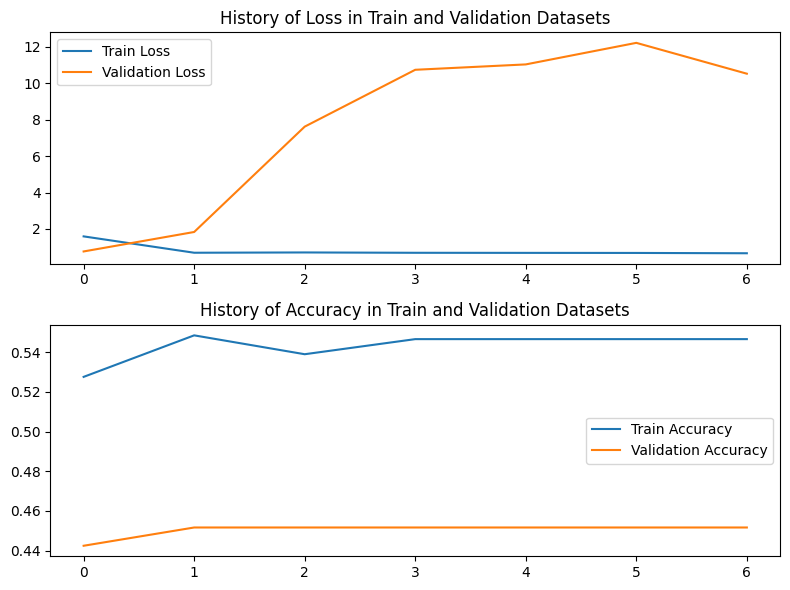

In [ ]:
plot_training(training_history,'cnn_train_plot')